## Steps
  - Data Collection
  - Understanding the data
  - Data Cleaning
  - Loading training set
  - Data Preprocessing - Images
  - Data Preprocessing - Captions
  - Data Preparation 
  - Word Embedding
  - Model Architure
  - Inference
  - Evaluation

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [157]:
## Read Text Captions
def readTextFile(path):
  with open(path) as f:
    captions = f.read()
  return captions
  

Last line is empty so discard it

In [158]:
captions = readTextFile('./Data/Fliker8k_text/Flickr8k.token.txt')
print(len(captions))
captions = captions.split("\n")[:-1]
print(len(captions))

3395237
40460


In [10]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

##### Dictionary to map each Image with the list of caption
d[abc.jpg] = [cap1,cap2,cap3,cap4,cap5]
d[img_id][list_of_captions]

In [159]:
f,s = captions[0].split('\t')
print(f.split('.'))
print(s)

['1000268201_693b08cb0e', 'jpg#0']
A child in a pink dress is climbing up a set of stairs in an entry way .


In [160]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split('.')[0]
    
    # if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(second)

In [38]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

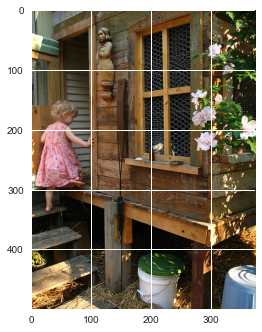

In [161]:
IMG_PATH = "./Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

## Data Cleaning

In [162]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1] # Try with and without it
    sentence = " ".join(sentence)
    return sentence

In [54]:
clean_text("A cat was sitting on the roof of house @ 827")

'cat was sitting on the roof of house'

In [14]:
# clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
        

In [56]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [60]:
# Write the data to text file i.e store the data specially in case of large dataset
f = open("descriptions_1.txt","w")
f.write(str(descriptions))
f.close()

In [59]:
## If don't want to write close statement
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary

In [163]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions = f.read()
    
print(type(descriptions))

<class 'str'>


In [164]:
json_acceptable_string = descriptions.replace("'","\"")
# replace all single quotes with double so that it becomes json acceptable object
descriptions = json.loads(json_acceptable_string)
print(type(descriptions))

<class 'dict'>


In [8]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [70]:
vocab = set()
vocab.update(["hello","bye"])
vocab.update(["hi","mango"])
vocab.update(["hello","apple"])
print(vocab)

{'hi', 'hello', 'apple', 'bye', 'mango'}


In [165]:
# Vocab
## set basically stores all the unique words.
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab Size :%d"% len(vocab))

Vocab Size :8424


In [166]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"%len(total_words))

Total Words 373837


In [16]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


### FIlter Word from Vocab acoording to certain threshold frequency

In [167]:
import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(freq_cnt)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [168]:
print(len(freq_cnt.keys()))

8424


In [169]:
# Sort this dictionary according to freq
# sorted_freq_cnt = sorted(freq_cnt,reverse=True,key=lambda x:x[1])
# we should not give dictionay here but a list to sort function
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filtering
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [20]:
sorted_freq_cnt

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [21]:
total_words

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'at',
 'people',
 'water',
 'red',
 'young',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'shirt',
 'down',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'person',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'holding',
 'up',
 'field',
 'small',
 'by',
 'large',
 'green',
 'one',
 'group',
 'yellow',
 'her',
 'walking',
 'children',
 'men',
 'into',
 'air',
 'beach',
 'near',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'off',
 'out',
 'rock',
 'next',
 'play',
 'orange',
 'looking',
 'pink',
 'player',
 'camera',
 'their',
 'pool',
 'hat',
 'jacket',
 'boys',
 'women',
 'around',
 'behind',
 'some',
 'background',
 'dirt',
 'toy',
 'soccer',
 'sits',
 'dressed',
 

In [170]:
len(total_words)

1845

Final Vocab Size is 1845 

#### Prepare Train/Test Data

In [171]:
train_file_data = readTextFile("Data/Fliker8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Fliker8k_text/Flickr_8k.testImages.txt")

In [23]:
print(train_file_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [24]:
train_file_data[-1]

'\n'

In [172]:
## Splilt along all new lines except last row
## Split along . to get image id
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [25]:
print(train[:10])
print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [173]:
# Prepare Description for the Training Data
## Add start and end token to our training data

train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)
        

In [18]:
train_descriptions["2699342860_5288e203ea"]

['startseq boy wearing red shirt is running through woodland endseq',
 'startseq child runs near some trees endseq',
 'startseq young boy is dancing around endseq',
 'startseq young boy with red short sleeved shirt and jeans runs by some trees endseq',
 'startseq the little boy in the red shirt stops to smile for the camera endseq']

## Transfer Learning
- Convert
    - Image to Features
    - Text to Features

#### Step-1 Image Extraction

In [70]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
model.layers[-2]

In [21]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [22]:
## model.input corresponds to input layer of renet model
model_new = Model(model.input,model.layers[-2].output)

In [7]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    # Normalization
    img = preprocess_input(img)
    return img

In [24]:
# img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


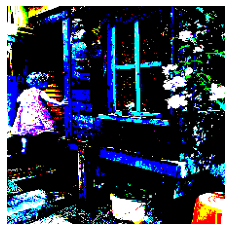

In [27]:
# plt.imshow(img[0])
# plt.axis("off")
# plt.show()

In [6]:
def encode_image(img):
    # Preprocess Image
    img = preprocess_img(img)
    # Pass it to ResNet
    feature_vector = model_new.predict(img)
#     print(feature_vector.shape)
    feature_vector = feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    # Save the encoding
    return feature_vector

In [37]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06536549, 0.16782689, 0.3251846 , ..., 0.0511154 , 0.32817915,
       1.0043331 ], dtype=float32)

We will save this data in a pickle file as this is a time consuming process to run 
this encoding again and again.

In [69]:
start = time()
encoding_train = {}
#image_id --> feature_vector extracted from Resnet Image
for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time Step %d "%ix)
        
end_t = time()
print("Total time taken : ",end_t-start)

NameError: name 'model_new' is not defined

In [39]:
# Store everything to the disk 
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [41]:
start = time()
encoding_test = {}
#image_id --> feature_vector extracted from Resnet Image
for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time Step %d "%ix)
        
end_t = time()
print("Total time taken(test) : ",end_t-start)

Encoding in Progress Time Step 0 
Encoding in Progress Time Step 100 
Encoding in Progress Time Step 200 
Encoding in Progress Time Step 300 
Encoding in Progress Time Step 400 
Encoding in Progress Time Step 500 
Encoding in Progress Time Step 600 
Encoding in Progress Time Step 700 
Encoding in Progress Time Step 800 
Encoding in Progress Time Step 900 
Total time taken(test) :  245.5236735343933


In [42]:
# Store everything to the disk 
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data pre-Processing for captions

In [43]:
len(total_words) # Vocab

1845

We are going to reserve the 0th index of dictionary.

In [174]:
word_2_idx = {}
idx_2_word = {}
for i,word in enumerate(total_words):
    word_2_idx[word] = i+1
    idx_2_word[i+1] = word

In [175]:
idx_2_word[1]

'in'

In [176]:
word_2_idx['cat']

585

In [30]:
print(len(idx_2_word))

1845


In [177]:
#Add Two special words
idx_2_word[1846] = "startseq"
word_2_idx["startseq"] = 1846

idx_2_word[1847] = "endseq"
word_2_idx["endseq"] = 1847

vocab_size = len(word_2_idx) + 1
print(vocab_size)

1848


In [181]:
# Store everything to the disk 
with open("./Storage/word_2_idx.pkl","wb") as f:
    pickle.dump(word_2_idx,f)
with open("./Storage/idx_2_word.pkl","wb") as f:
    pickle.dump(idx_2_word,f)

In [32]:
print(len(idx_2_word))

1847


In [178]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


## Data Loader(GENERATOR)


In [134]:
# train_descriptions -> dictionary which matches imgID with Captions
def data_generator(train_descriptions,encoding_train,word_2_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n = 0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_2_idx[word] for word in desc.split() if word in word_2_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]   # take all prev. entries
                    yi = seq[i]
                    
                    # 0 denotes padding word
                    #[xi] bcz it accepts 2D matrix so we convert xi into 2D
                    # 0 will be added after numbers so "post"
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0] # Converting to one-hot vectors
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0
                

## Word Embedding

In [36]:
f = open("./glove.6B.50d.txt",encoding='utf8')

In [38]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [40]:
f.close()

In [39]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [46]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_2_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
#     print(matrix.shape)
    return matrix


In [47]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


1848 is your vocab size

In [48]:
embedding_matrix[1847]  # start and end will be zero as they are not in our glove embeddings

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model Architecture

In [127]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [128]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
# after embeddings add some dropouts and then pass throgh LSTM
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [129]:
# Add inputs and decode them
# Ddecoder
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1) # Add some non-linearlity to model
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [130]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 50)       92400       input_10[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_9[0][0]                    
____________________________________________________________________________________________

You can see add layer having 2 layers going in it

In [131]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [132]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

## Training Of Model

In [124]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [72]:
# with open('filename', 'rb') as f:
#     x = pickle.load(f)
with open("encoded_train_features.pkl","rb") as f:
    encoding_train=pickle.load(f)

In [137]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_2_idx,max_len,batch_size)
#         model.fit_generator(generator,epochs,steps,verbose=1)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [138]:
train()

2000/2000 [==============================] - 606s 303ms/step - loss: 2.4061


In [139]:
model = load_model('./model_weights/model_9.h5')

In [140]:
model

In [113]:
encoding_train['2513260012_03d33305cf']

array([0.3470795 , 0.51159084, 0.08728848, ..., 1.1897296 , 0.04043847,
       0.1527106 ], dtype=float32)

## Predictions

In [144]:
with open("encoded_test_features.pkl","rb") as f:
    encoding_test=pickle.load(f)

In [154]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_2_idx[w] for w in in_text.split() if w in word_2_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_2_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

group of people are standing in front of mountain


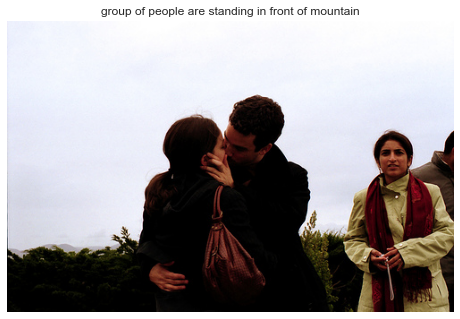

brown dog is jumping over fence


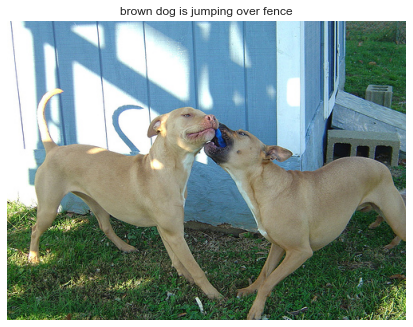

dog is playing with toy on blanket


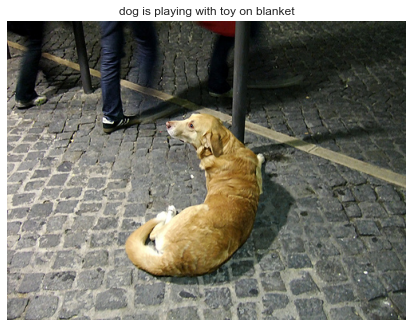

man in blue shirt and jeans is riding red bike on wooden bridge


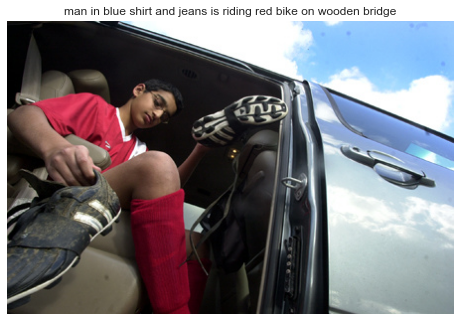

man with helmet and hat


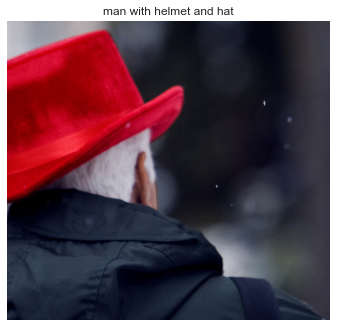

man in jeans and jeans is standing on skateboard


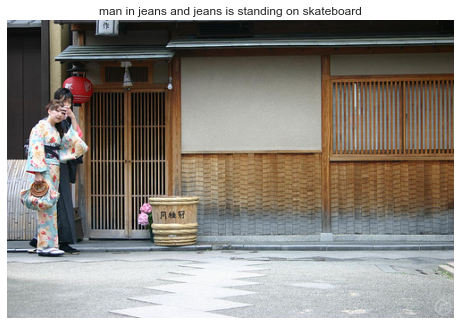

dog chews on ball


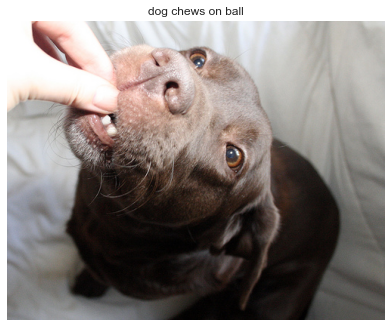

dog chews on ball


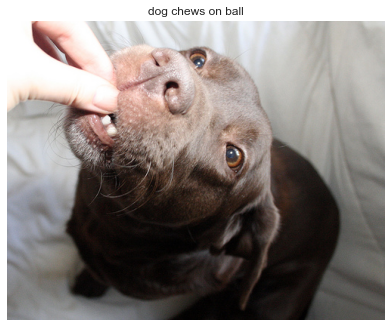

man is roller trick on his skateboard


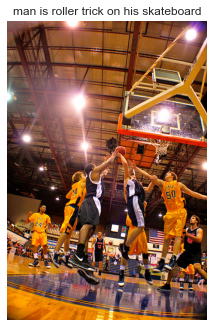

man is helping girl in the air


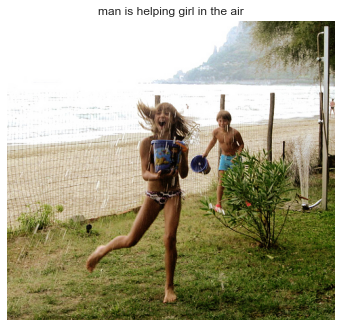

black dog with red collar is running through the snow


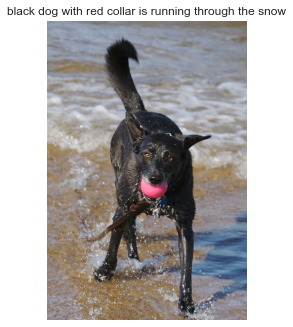

dog running through the grass


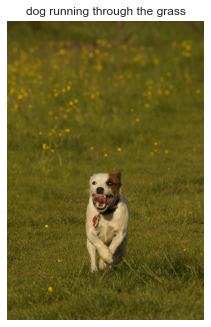

little girl swings on swing set


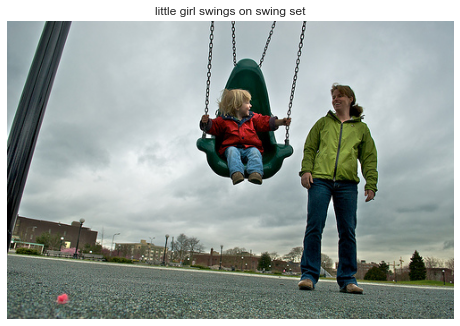

little boy is jumping over red and white bar


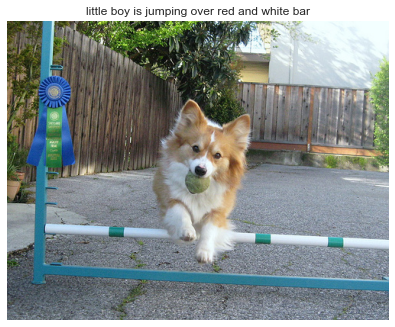

man in black shirt and cast shoes is performing tricks on skateboard


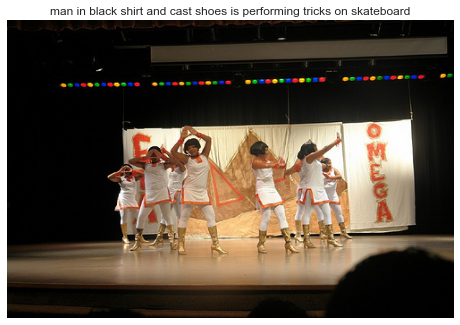

In [155]:
## Generate Some Random Images
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    print(caption)
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
